# Imports and Hugging Face Login

In [1]:
!pip install huggingface-hub
!pip install datasets > delete.txt

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
import torch
import pickle
from huggingface_hub import hf_hub_download
from datasets import load_dataset, Image
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from torchvision import models
from timm import create_model

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
!huggingface-cli login
# use appropiate token


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineGrained).
The token `CIS 5190 Project 3` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-au

# Models

In [15]:
class SwinGPSModel(nn.Module):
    def __init__(self, pretrained=True):
        super(SwinGPSModel, self).__init__()
        # Load the pretrained Swin Transformer
        self.backbone = create_model('swin_base_patch4_window7_224', pretrained=pretrained)

        # Get the number of features from the backbone
        num_features = self.backbone.num_features
        self.backbone.head = nn.Identity()

        # Define the regression head
        self.regression_head = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(num_features, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )

    def forward(self, x):
        # Forward pass through the backbone
        features = self.backbone(x)
        features = features.permute(0, 3, 1, 2)
        return self.regression_head(features)

# Loading Test Dataset

In [16]:
from torch.utils.data import Dataset
class GPSImageDataset(Dataset):
    def __init__(self, hf_dataset, transform, lat_mean=None, lat_std=None, lon_mean=None, lon_std=None):
        self.hf_dataset = hf_dataset
        self.transform = transform

        # Normalize the latitude and longitude
        self.latitudes = np.array(hf_dataset['Latitude'])
        self.longitudes = np.array(hf_dataset['Longitude'])
        self.latitude_mean = lat_mean if lat_mean is not None else self.latitudes.mean()
        self.latitude_std = lat_std if lat_std is not None else self.latitudes.std()
        self.longitude_mean = lon_mean if lon_mean is not None else self.longitudes.mean()
        self.longitude_std = lon_std if lon_std is not None else self.longitudes.std()

        self.normalized_latitudes = (self.latitudes - self.latitude_mean) / self.latitude_std
        self.normalized_longitudes = (self.longitudes - self.longitude_mean) / self.longitude_std

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        image = self.hf_dataset[idx]['image']
        latitude = self.normalized_latitudes[idx]
        longitude = self.normalized_longitudes[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor([latitude, longitude], dtype=torch.float)

In [17]:
from torchvision import transforms, models
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

inference_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [18]:
dataset_test = load_dataset("gydou/released_img")

In [19]:
lat_mean = 39.9517411499467
lat_std = 0.0006914493505038013
lon_mean =  -75.19143213125122
lon_std =  0.0006539239061573955

test_dataset = GPSImageDataset(
    hf_dataset=dataset_test['train'],
    transform=inference_transform,
    lat_mean=lat_mean,
    lat_std=lat_std,
    lon_mean=lon_mean,
    lon_std=lon_std
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=4
)

# Loading the Model

In [13]:
pth_file_path = hf_hub_download(repo_id= "CIS-5190-CIA/SWIN_Model", filename="best_swin_gps_model (1).pth")

best_swin_gps_model (1).pth:   0%|          | 0.00/348M [00:00<?, ?B/s]

In [20]:
# Instantiate the model
model = SwinGPSModel(pretrained=False)

# Load the weights from the downloaded .pth file
model.load_state_dict(torch.load(pth_file_path, map_location=torch.device("cpu")))

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Set the model to evaluation mode
model.eval()

print("Model loaded successfully!")

<ipython-input-20-85f55b19993d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(pth_file_path, map_location=torch.device("cpu")))


Model loaded successfully!


# Prediction

In [21]:
def evaluate_final_rmse(ensemble_model, data_loader, lat_mean, lon_mean, lat_std, lon_std):
    """
    Evaluate the ensemble model on a given dataset and compute final RMSE in meters.
    """
    ensemble_model.eval()
    total_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for images, targets in data_loader:
            images, targets = images.to(device), targets.to(device)
            outputs = ensemble_model(images)
            preds_denorm = outputs.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
            actuals_denorm = targets.cpu().numpy() * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

            for pred, actual in zip(preds_denorm, actuals_denorm):
                distance = geodesic((actual[0], actual[1]), (pred[0], pred[1])).meters
                total_loss += distance ** 2
            total_samples += targets.size(0)

    final_loss = total_loss / total_samples
    final_rmse = np.sqrt(final_loss)

    return final_loss, final_rmse

In [22]:
final_test_loss, final_test_rmse = evaluate_final_rmse(
    ensemble_model=model,
    data_loader=test_dataloader,
    lat_mean=lat_mean,
    lon_mean=lon_mean,
    lat_std=lat_std,
    lon_std=lon_std
)

print(f"Test Loss (meters^2): {final_test_loss:.2f}")
print(f"Test RMSE (meters): {final_test_rmse:.2f}")

Test Loss (meters^2): 6268.61
Test RMSE (meters): 79.17


# Visualization

In [23]:
def visualize_predictions(all_preds, all_actuals, lat_mean, lon_mean, lat_std, lon_std):
    """
    Visualizes actual and predicted GPS coordinates on a scatter plot,
    including error lines connecting each prediction to its corresponding actual point.
    """

    all_preds_denorm = all_preds * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])
    all_actuals_denorm = all_actuals * np.array([lat_std, lon_std]) + np.array([lat_mean, lon_mean])

    plt.figure(figsize=(10, 5))

    plt.scatter(all_actuals_denorm[:, 1], all_actuals_denorm[:, 0], label='Actual', color='blue', alpha=0.6)
    plt.scatter(all_preds_denorm[:, 1], all_preds_denorm[:, 0], label='Predicted', color='red', alpha=0.6)
    for i in range(len(all_actuals_denorm)):
        plt.plot(
            [all_actuals_denorm[i, 1], all_preds_denorm[i, 1]],
            [all_actuals_denorm[i, 0], all_preds_denorm[i, 0]],
            color='gray', linewidth=0.5
        )

    plt.legend()
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Actual vs. Predicted GPS Coordinates with Error Lines')
    plt.grid(True)
    plt.show()

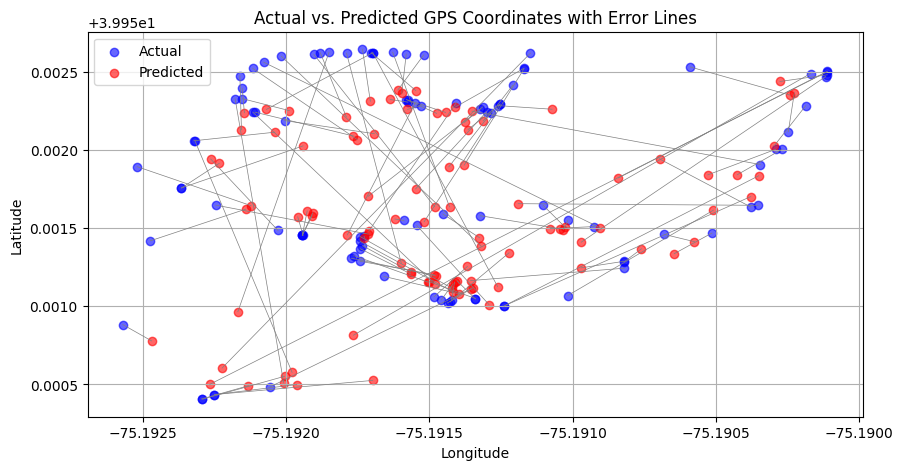

In [24]:
all_preds = []
all_actuals = []

with torch.no_grad():
    for images, targets in test_dataloader:
        images = images.to("cuda")
        targets = targets.to("cuda")

        preds = model(images)

        all_preds.append(preds.cpu().numpy())
        all_actuals.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_actuals = np.concatenate(all_actuals, axis=0)

visualize_predictions(
    all_preds=all_preds,
    all_actuals=all_actuals,
    lat_mean=lat_mean,
    lon_mean=lon_mean,
    lat_std=lat_std,
    lon_std=lon_std
)